In [34]:
empty(5)

array([  0.00000000e+000,   0.00000000e+000,   6.94282851e-310,
         6.94282851e-310,   6.94282851e-310])

In [44]:
# get beta distributions corresponding to 95% CIs reported in Mercer 2007

from numpy import *
from scipy.stats import beta
from scipy.optimize import fsolve

a = empty(5)
b = empty(5)

# < 1 week
[a[0], b[0]] = fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.144, 0.442),
    [1,1]
    )

# 7-13 days
[a[1], b[1]] = fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.061, 0.302),
    [1,1]
    )

# 14-27 days
[a[2], b[2]] = fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.133, 0.310),
    [1,1]
    )

# 28-41 days
[a[3], b[3]] = fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.085, 0.299),
    [1,1]
    )

# 42 days and over
[a[4], b[4]] = fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.055, 0.564),
    [1,1]
    )


In [46]:
tps = array([0., 7., 14., 28., 42., Inf])
theta = exp(-0.1*tps[:5]) - exp(-0.1*tps[1:])
print theta
print beta.pdf(theta, a, b, loc=0, scale=1)

[ 0.5034147   0.24998834  0.1857869   0.04581449  0.01499558]
[ 0.1340404   2.11925441  7.8017892   0.07731368  0.17408397]


In [103]:
# Metropolis-Hastings to get a sample for rate of treatment

n_sample = 10000

i = 0
att_symp = empty(n_sample+1000) # testing rate per person per year. Allow 1000 extra samples for burn-in
ll = empty(n_sample+1000) # log-likelihood
old = 0.04 # starting sample value
new = 0.04 # starting sample value

# simulate probabilities corresponding to PATSI data

# proportion expected in each time window
tps = array([0., 7., 14., 28., 42., Inf])
simp_new = exp(-new*tps[:5]) - exp(-new*tps[1:])

acc=0.
while i < n_sample+1000: # to do samples for p_test_symp
    
    new = random.normal(old, 0.05) # generate a sample from normal distribution
    
    if new < 0:
        att_symp[i] = old # reject
        ll[i] = -1e10
    else:
        simp_old = exp(-old*tps[:5]) - exp(-old*tps[1:])
        simp_new = exp(-new*tps[:5]) - exp(-new*tps[1:])

        if sum(simp_new > 0) != len(tps) - 1:
            att_symp[i] = old # reject
            ll[i] = -1e10
        else:
            # simulate probabilities corresponding to the PATSI data
            log_ratio = sum(beta.logpdf(simp_new, a, b, loc=0, scale=1)) - sum(beta.logpdf(simp_old, a, b, loc=0, scale=1))
    
            if log(random.uniform(0,1)) <  log_ratio:
                att_symp[i] = new # accept
                ll[i] = sum(beta.logpdf(simp_new, a, b, loc=0, scale=1))
                old = new
                acc = acc+1
            else:
                att_symp[i] = old # reject
                ll[i] = sum(beta.logpdf(simp_old, a, b, loc=0, scale=1))
        
    i = i+1
    
att_symp = att_symp[1000:] # remove burn-in samples
ll = ll[1000:] # log-likelihood
    
print acc/(n_sample+1000) # print the proportion of samples accepted
print mean(att_symp)*365.25

0.220090909091
14.2101171412


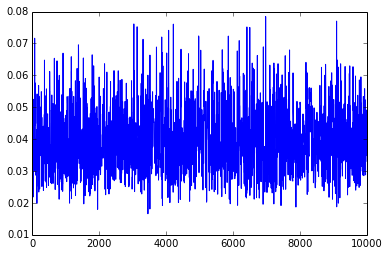

In [123]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.plot(att_symp[range(10000)])

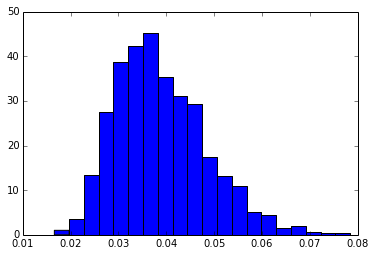

In [107]:
h1=plt.hist(att_symp, bins=20, normed=True)

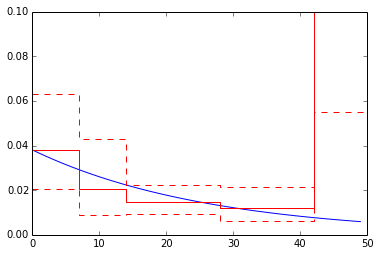

In [102]:
plt.plot(range(50),median(att_symp)*exp(-median(att_symp)*array(range(50))),'b')
#plt.plot(range(50),percentile(att_symp, 2.5)*exp(-percentile(att_symp, 2.5)*array(range(50))),'b--')
#plt.plot(range(50),percentile(att_symp, 97.5)*exp(-percentile(att_symp, 97.5)*array(range(50))),'b--')

plt.ylim([0,0.1])
plt.plot([0,7,7,14,14,28,28,42,42,50], [0.267/7, 0.267/7, 0.144/7, 0.144/7, 0.208/14, 0.208/14, 0.166/14, 0.166/14, 0.215, 0.215], 'r')
plt.plot([0,7,7,14,14,28,28,42,42,50], [0.144/7, 0.144/7, 0.061/7, 0.061/7, 0.133/14, 0.133/14, 0.085/14, 0.085/14, 0.055, 0.055], 'r--')
plt.plot([0,7,7,14,14,28,28,42,42,50], [0.442/7, 0.442/7, 0.302/7, 0.302/7, 0.310/14, 0.310/14, 0.299/14, 0.299/14, 0.564, 0.564], 'r--')

In [109]:
# now the old method. Read in data:
# women
import csv

with open('../../../data/MSTIC/mstic_timedata_f.csv', 'rU') as csvfile:
    timereader = csv.reader(csvfile, delimiter=',')
    times = [int(row[0]) for row in timereader]
times_f = times[0:43]
with open('../../../data/MSTIC/mstic_timedata_f.csv', 'rU') as csvfile:
    timereader = csv.reader(csvfile, delimiter=',')
    prop = [int(row[1]) for row in timereader]
prop_f = prop[0:43]
with open('../../../data/MSTIC/mstic_timedata_f.csv', 'rU') as csvfile:
    timereader = csv.reader(csvfile, delimiter=',')
    cumprop = [int(row[2]) for row in timereader]
cumprop_f = cumprop[0:43]


In [111]:
%run multinomial_pmf.py

# Metropolis-Hastings to get a sample for rate of treatment in women

i = 0
att_symp_f = empty(n_sample+1000) # testing rate per person per year
ll_f = empty(n_sample+1000) # log-likelihood
old = 15 # starting sample value
new = 15 # starting sample value
# simulate probabilities corresponding to MSTIC data
simp_new = exp(-array(times_f)*new/365.25) - append(exp(-array(times_f[1:len(times_f)])*new/365.25),0)

acc=0.
while i < n_sample+1000: # to do samples for p_test_symp
    
    new = random.normal(old, 2) # generate a sample from normal distribution
    
    if new < 0:
        att_symp_f[i] = old # reject
        ll_f[i] = -1e10
    else:
        simp_old = exp(-array(times_f)*old/365.25) - append(exp(-array(times_f[1:len(times_f)])*old/365.25), 0)
        simp_new = exp(-array(times_f)*new/365.25) - append(exp(-array(times_f[1:len(times_f)])*new/365.25), 0)

        if sum(simp_new > 0) != len(times_f):
            att_symp_f[i] = old # reject
            ll_f[i] = -1e10
        else:
            # simulate probabilities corresponding to the MSTIC data
            m_old = Multinomial(simp_old)
            m_new = Multinomial(simp_new)
            log_ratio = m_new.log_pmf(prop_f) - m_old.log_pmf(prop_f)
    
            if log(random.uniform(0,1)) <  log_ratio:
                att_symp_f[i] = new # accept
                ll_f[i] = m_new.log_pmf(prop_f)
                old = new
                acc = acc+1
            else:
                att_symp_f[i] = old # reject
                ll_f[i] = m_old.log_pmf(prop_f)
        
    i = i+1
    
att_symp_f = att_symp_f[1000:] # remove burn-in samples
ll_f = ll_f[1000:] # log-likelihood
    
print acc/(n_sample+1000) # print the proportion of samples accepted
print mean(att_symp_f)

0.343181818182
12.4012649116


(5, 30)

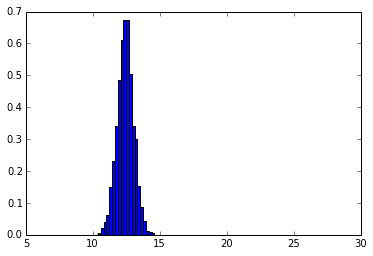

In [117]:
h2=plt.hist(att_symp_f, bins=20, normed=True)
plt.xlim([5,30])

(5, 30)

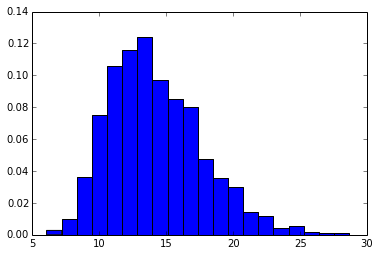

In [118]:
h1=plt.hist(att_symp*365.25, bins=20, normed=True)
plt.xlim([5,30])